<a href="https://colab.research.google.com/github/NeerajSahani/Fashion-GANs/blob/main/Fashion_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [10]:
images = np.concatenate((train_images, test_images))
images = images.reshape(-1, 28, 28, 1).astype(np.float_)
images = (images - 127.5)/127.5

<h1>Constants</h1>

In [11]:
EPOCHS = 100
latent_dim = 100
BATCH_SIZE = 256
BUFFER_SIZE = 70000
num_samples_to_generate = 16
seed = tf.random.normal([num_samples_to_generate, latent_dim])

In [12]:
images = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
generator = tf.keras.Sequential()
generator.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim, )))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((7, 7, 256)))

generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=True))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=True))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=True, activation='tanh'))

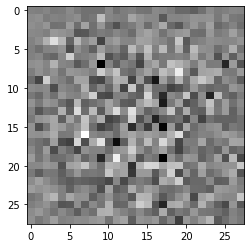

In [15]:
noise = tf.random.normal([1, latent_dim])
gen_img = generator(noise, training=False)
plt.imshow(gen_img[0, :, :, 0], cmap='gray')

In [17]:
discriminator = tf.keras.Sequential()
discriminator.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))

In [18]:
decision = discriminator(gen_img, training=False)
print(decision)

tf.Tensor([[0.0032769]], shape=(1, 1), dtype=float32)


In [19]:
cross_entropy = tf.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [24]:
checkpoint_dir = './fashion_mnist_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer, 
    discriminator_optimizer=discriminator_optimizer,
    generator = generator,
    discriminator = discriminator
    )

In [31]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, latent_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # Calculate Loss
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Calculate gradient
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # User gradients to update weights
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))




In [26]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [29]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  
  #Final Output
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

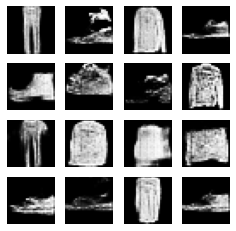

In [35]:
train(images, EPOCHS)

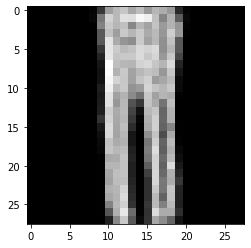

In [38]:
plt.imshow(generator(seed)[0, :, :, 0], cmap='gray')